# 卷积神经网络和TensorFlow介绍

本教程对CNN和TensorFlow做了非常简洁的介绍，与当前常见的TensorFlow 和CNN教材不同，我们更多的侧重于TensorFlow的后台机制。本教程基于计算机来阐述，其可用于TensorFlow的定义，执行，储存等。同样，它也适用于其他任务。

教程安排如下:

1. [基础TensorFlow应用](#基础TensorFlow应用)
2. [TensorFlow中的计算图](#TensorFlow中的计算图)
3. [作为计算图的CNN](#作为计算图的CNN)
4. [练习](#练习)

我们的教程针对的是TensorFlow的**graph execution**模式，与最近的TensorFlow版本引入的**eager execution**相比，它可以在不首先构建计算图的情况下即时执行计算。

本教程仅介绍 inference任务。


在以下教程中，我们将提供已构建的TensorFlow模型，请保存以便接下来的学习。

## 效果预期

1. 学会使用基础的TensorFlow。
2. 理解TensorFlow模型结构并学会从模型中提取信息。
3. 学会如何可视化CNN中间输出。


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## TensorFlow基础使用

一方面，TensorFow是著名的机器学习构架，开发者能够轻松的在上面建立自己的模型。另一方面，TensorFow是嵌入在Python中的域特定语言（DSL）。作为域特定语言，TensorFlow提供了 primitives, 或者 APIs来构建计算机图用于机器学习模型。因此，在本教程中，我们采用TensorFlow作为编程语言：我们首先介绍TensorFlow中典型编程语言的元素，如语法，变量，数据类型，文字和运算符; 接下来，将展示如何执行TensorFlow构建的程序; 最后，会有一个关于使用TensorFlow的提示和技巧的简短列表

我们将在以下部分中研究TensorFlow中的计算图机制。

### 基本语法

当你安装好TensorFlow，我们还需要在python中导入如下代码（若没有安装好，请按照本教程[tutorial](https://www.tensorflow.org/install/)进行安装）


In [2]:
# import tensorflow and set its alias as "tf"
import tensorflow as tf

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


在TensorFlow DSL中的可操作基单元是 **tensor**（相关文档 [tf.Tensor](https://www.tensorflow.org/api_docs/python/tf/Tensor)）， 简单来说，tensor是一个N维数组，和NumPy中的[ndarray](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.ndarray.html)类似。下面的例子展示了如何用常数来构建tensor。

In [3]:
tf.constant([[1.0, 2.0], [3.0, 4.0]]) # This is a 2D Matrix or a 2D array

<tf.Tensor 'Const:0' shape=(2, 2) dtype=float32>

除常数外，还可以创建**变量**tensor, 点击[document](https://www.tensorflow.org/programmers_guide/variables)查看详细。可以通过`get_variable`创建变量的名称和大小，如下所示。Tensor名称在其[name scope](https://www.tensorflow.org/api_docs/python/tf/name_scope)内只能是唯一的。

In [4]:
tf.get_variable('a', [2, 2]) # This is tensor 'a' in a global TF scope

<tf.Variable 'a:0' shape=(2, 2) dtype=float32_ref>

然后，我们可以利用TensorFlow里的**算子**[operators](https://www.tensorflow.org/api_docs/python/tf/Operation)来构建计算。 `tf.matmul` 是一个直观的例子， 它在两个2维tensors之间执行矩阵乘法。TensorFlow算子返回的对象是表征计算结果的tensor。

In [5]:
tf.matmul(tf.constant([[1.0, 2.0], [3.0, 4.0]]), tf.constant([[1.0, 2.0], [3.0, 4.0]]))

<tf.Tensor 'MatMul:0' shape=(2, 2) dtype=float32>

要运行计算，即获得tensor中的内容，我们需要使用tf.Session（参见 [here](https://www.tensorflow.org/api_docs/python/tf/Session)）来初始化环境，以便来执行TensorFlow的程序。这部分不做深入探究。

注意每个变量在开始前都需要初始化，下面的示例使用`random_normal_initializer`来初始化tensor b的内容，使其为随机值且服从正态分布。

In [6]:
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.get_variable('b', [2, 2], initializer=tf.random_normal_initializer())
c = tf.matmul(a, b)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(c))

[[ 1.2486579e+00  1.5110373e-03]
 [ 4.2668915e+00 -5.9322524e-01]]


## TensorFlow中的计算图

大多数的计算机程序都可以用一张计算图来表示。由TensorFlow构建的程序明确地初始化了它的计算图。由TensorFlow构建的计算图是[数据流图](https://www.tensorflow.org/programmers_guide/graphs#why_dataflow_graphs)，其中每个节点表示计算（或操作），每个边是数据。下面的gif显示了如何为双层MLP（多层感知器）构建数据流图。在第一层，输入数据将首先通过矩阵乘法(`tf.matmul`)，偏向量加法(`BiasAdd`)和非线性激励(`tf.nn.relu`)。第二层在相同的设置下，处理除ReLU激励函数外的输出数据。权重和偏差向量是可变tensor。 注意，此图中还初始化了训练节点（梯度，更新）。

![](https://www.tensorflow.org/images/tensors_flowing.gif)

### 获得图像内容

本教程的目的主要是为了了解TensorFlow的机制以进一步进行优化和部署。这意味着有必要访问我们构建的图中的内容。假设我们构建的图形与动画图形所示的计算完全相同，从输入到`Softmax`。


In [7]:
g = tf.Graph() # build a new graph
with g.as_default():
    # the second argument is the shape in this case 28x28x1 image
    input_tensor = tf.placeholder(tf.float32, [28, 28, 1])
    
    # reshape it as a column vector
    x = tf.reshape(input_tensor, [1, 784], name='x')
    
    # The first perceptron layer
    W1 = tf.get_variable('W1', [784, 1024])
    b1 = tf.get_variable('b1', [1024])
    
    # Perform the matrix multiply and add bias
    y1 = tf.nn.relu(tf.nn.bias_add(tf.matmul(x, W1), b1), name='y1')
    
    # The second perceptron layer
    W2 = tf.get_variable('W2', [1024, 10])
    b2 = tf.get_variable('b2', [10])
    y2 = tf.nn.bias_add(tf.matmul(y1, W2), b2, name='y2')
    
    logits = tf.nn.softmax(y2, name='logits') # softmax output is named as "logits"

TensorFlow把所有与图相关的信息都放在tf.Graph [class](https://www.tensorflow.org/api_docs/python/tf/Graph)中，就像上例中的`g`一样。该图形对象将图形的定义保存为[`GraphDef`](https://www.tensorflow.org/api_docs/python/tf/GraphDef)，可以通过`as_graph_def()`访问。你可以通过其`node`属性遍历`GraphDef`中的每个节点。 每个节点都有名称，`op`用于操作名称，`input`用于输入到当前节点的节点名称列表，以及其他可访问属性。在下面的例子中，我们输出每个`MatMul`节点的属性。定义节点的语法是一个[Protocol Buffer](https://developers.google.com/protocol-buffers/)，可以查阅其文档以获得更多细节。

In [8]:
graph_def = g.as_graph_def()
for node in graph_def.node:
    if node.op == 'MatMul':
        print(node)

name: "MatMul"
op: "MatMul"
input: "x"
input: "W1/read"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "transpose_a"
  value {
    b: false
  }
}
attr {
  key: "transpose_b"
  value {
    b: false
  }
}

name: "MatMul_1"
op: "MatMul"
input: "y1"
input: "W2/read"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "transpose_a"
  value {
    b: false
  }
}
attr {
  key: "transpose_b"
  value {
    b: false
  }
}



除了访问节点定义，我们还可以通过`tf.Grap`的`get_tensor_by_namemethod` 方法来读取每个图中每一节点的内容。这个方法会返回一个`Tensor`对象，可以通过`sess.run`读取其中的内容。请注意：tensor的名字并不完全是对应节点的名字，我们需要附加上[device placement](https://www.tensorflow.org/programmers_guide/graphs#placing_operations_on_different_devices)。 在后面的例子中，权重`W1`被放到`index0`的设备上。

In [9]:
with tf.Session(graph=g) as sess: # we need to explicitly set the graph or the default graph will be used.
    sess.run(tf.global_variables_initializer())
    
    # read the content of initialised W1
    W1_tensor = g.get_tensor_by_name('W1:0')
    print(sess.run(W1_tensor))

[[ 0.04186983  0.01554188 -0.04810648 ... -0.0057848  -0.04940532
   0.04064221]
 [-0.0357748   0.05161197  0.03711758 ... -0.04559297  0.0094061
  -0.00094092]
 [ 0.04965667  0.02794094  0.04235747 ... -0.0361556   0.00126217
  -0.02915845]
 ...
 [ 0.01335635  0.00402979 -0.03288927 ... -0.01393164 -0.03195806
  -0.01588652]
 [-0.04886859  0.05068135 -0.01241539 ...  0.04052348  0.05338682
  -0.02036126]
 [-0.00651863 -0.04804414  0.03801457 ... -0.02860732  0.04754426
  -0.02520439]]


要读取取决于`Input`节点的tensor内容，我们需要在会话执行时向其提供内容。可以查阅资料https://www.tensorflow.org/api_docs/python/tf/placeholder, 如果还是不能完全明白TensorFlow，可以看这个网址： [Link](https://github.com/ringochu/TensorFlowDemo)这是一个小的展示，在一张简洁的海报中总结了TensorFlow 以及 NumPy的基础知识。

In [10]:
with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    # read the final classification result of a random image
    logits_tensor = g.get_tensor_by_name('logits:0')
    print(sess.run(logits_tensor, feed_dict={input_tensor: np.random.random((28, 28, 1))}))

[[0.03610415 0.06912688 0.07223938 0.16913089 0.0772726  0.1951995
  0.07214345 0.18331014 0.04666999 0.07880298]]


## CNN作为计算图

基于前面的讨论，我们可以构建卷积神经网络（[CNN](https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148)）并在TensorFlow中读取其结构和系数。CNN可以看作是包含卷积层的特殊计算图，在TensorFlow中是`tf.nn.conv2d`。(https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) 可以在本教程中访问**卷积层**原理的详细信息。

在传统的CNN网络中，每层的输入和输出都是**特征图**，通常是3-Dtensor(批量输入时为4-D). 一幅特征图可以被看成一个多通道图像，它能够代表自然图像或者从潜在的空间里提取的特征。每个特征图的形状是空间特征图的高度和宽度，也是图像通道的数量。卷积层在每个空间特征映射中执行2D卷积，并将结果汇总在一起用于不同的输出通道。除了卷积层之外，最大池层对于减小特征映射的大小以提取更高级别的特征也同样重要。

我们在TensorFlow中构建一个CNN的实例，其用于手写体数字的识别。这个CNN的架构被称为[LeNet](http://yann.lecun.com/exdb/lenet/)。它需要使用MNIST数据集进行训练。类似的教程可以在以下链接找到：(https://www.tensorflow.org/tutorials/deep_cnn)

In [11]:
def lenet(images, keep_prob):
    """
    Args:
        images: a 4-D tensor that holds batched input images
    Return:
        A tensor that contains classification probabilities result, and a dictionary
        of all intermediate tensors.
    """    
    end_points = {}
    # Input shape of 28,28,1 and -1 is just for TF purposes
    end_points['images'] = tf.reshape(images, [-1, 28, 28, 1])
    
    # Define the scope
    with tf.variable_scope('conv1'):
        # Define the weights for the convolution aka. Kernel size, kernel size, stride and number of filters
        w1 = tf.get_variable('weights', [5, 5, 1, 32])
        
        # Define the bias
        b1 = tf.get_variable('biases', [32],
                             initializer=tf.zeros_initializer())
        # Perform the computation and apply ReLU function
        # First do the conv2d with weights w1 in the SAME namespace then add the bias, later activation function
        end_points['conv1'] = tf.nn.relu(
            tf.nn.conv2d(end_points['images'], w1, [1, 1, 1, 1], 'SAME') + b1)
    
    # Add a max-pooling operation with kernel 2x2 and stride 1
    end_points['pool1'] = tf.nn.max_pool(
        end_points['conv1'], [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    with tf.variable_scope('conv2'):
        w2 = tf.get_variable('weights', [5, 5, 32, 64])
        b2 = tf.get_variable('biases', [64],
                             initializer=tf.zeros_initializer())
        end_points['conv2'] = tf.nn.relu(
            tf.nn.conv2d(end_points['pool1'], w2, [1, 1, 1, 1], 'SAME') + b2)
    end_points['pool2'] = tf.nn.max_pool(
        end_points['conv2'], [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    end_points['flatten'] = tf.reshape(end_points['pool2'], [-1, 7 * 7 * 64])
    with tf.variable_scope('fc3'):
        w3 = tf.get_variable('weights', [7 * 7 * 64, 1024])
        b3 = tf.get_variable('biases', [1024],
                             initializer=tf.zeros_initializer())
        end_points['fc3'] = tf.nn.relu(tf.matmul(end_points['flatten'], w3) + b3)
        
    end_points['dropout'] = tf.nn.dropout(end_points['fc3'], keep_prob)
    with tf.variable_scope('fc4'):
        w4 = tf.get_variable('weights', [1024, 10])
        b4 = tf.get_variable('biases', [10],
                             initializer=tf.zeros_initializer())
        end_points['fc4'] = tf.matmul(end_points['fc3'], w4) + b4
    
    return end_points['fc4'], end_points

然后，我们基于MNIST数据集训练了这个CNN网络（参考 https://www.tensorflow.org/versions/r1.0/get_started/mnist/beginners)

以下是我们用于训练模型的代码段

In [12]:
# NOTE: You don't need to run this code snippet since we have already trained it
# and it will consume lots of resources on our server.

from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("../data/MNIST_data/", one_hot=True)

g = tf.Graph()
with g.as_default():
    images = tf.placeholder(tf.float32, shape=[None, 784])
    labels = tf.placeholder(tf.float32, shape=[None, 10])
    keep_prob = tf.placeholder(tf.float32)
    logits, end_points = lenet(images, keep_prob)
    
    # Nodes for training
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
    train = tf.train.AdadeltaOptimizer(1e-3).minimize(loss)
    
    # accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    saver = tf.train.Saver()
    
    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())

        for i in range(20000):
            batch_xs, batch_ys = mnist.train.next_batch(50)
            _, loss_val = sess.run([train, loss],
                                   feed_dict={images: batch_xs,
                                              labels: batch_ys,
                                              keep_prob: 0.5})
        
            if i % 100 == 0:
                print('Loss value of a training batch at step %5d: %f' % (i, np.mean(loss_val)))
            if i % 1000 == 0:
                acc = sess.run(accuracy,
                               feed_dict={images: mnist.test.images,
                                          labels: mnist.test.labels,
                                          keep_prob: 1.0})
                print('Accuracy after running %5d steps: %f' % (i, acc))
        
        # save the trained model
        saver.save(sess, "mnist_lenet_log/")

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
Loss value of a training batch at step     0: 2.272092
Accuracy after running     0 steps: 0.098200
Loss value of a training batch at step   100: 2.291337
Loss value of a training batch at step   200: 2.254262
Loss value of a training batch at step   300: 2.271129
Loss value of a training batch at step   400: 2.270882
Loss value of a training batch at step   500: 2.252652
Loss value of a training batch at step   600: 2.220472
Loss value of a training batch at step   700: 2.219046
Loss value of a training batch at step   800: 2.204627
Loss value of a training batch at step   900: 2.211274
Loss value of a training batch at step  1000: 2.205071
Accuracy after running  1000 steps: 0.434200
Loss value of a training batch at step  1100: 2.217518
Loss value of a training

Loss value of a training batch at step 13400: 0.640367
Loss value of a training batch at step 13500: 0.711528
Loss value of a training batch at step 13600: 0.595643
Loss value of a training batch at step 13700: 0.700417
Loss value of a training batch at step 13800: 0.572912
Loss value of a training batch at step 13900: 0.590981
Loss value of a training batch at step 14000: 0.523539
Accuracy after running 14000 steps: 0.867300
Loss value of a training batch at step 14100: 0.647697
Loss value of a training batch at step 14200: 0.564996
Loss value of a training batch at step 14300: 0.499261
Loss value of a training batch at step 14400: 0.655310
Loss value of a training batch at step 14500: 0.479925
Loss value of a training batch at step 14600: 0.569616
Loss value of a training batch at step 14700: 0.540437
Loss value of a training batch at step 14800: 0.602443
Loss value of a training batch at step 14900: 0.534764
Loss value of a training batch at step 15000: 0.629089
Accuracy after runni

## 练习

在本练习中，建议你在每个卷积层和最大池化层之后可视化中间特征图。我们提供以下代码片段的基本构架，你需要完成下面的任务：

1.	正确识别lenet函数中所有卷积层和最大池化层的`end_point` tensor。 注意，看到多个划线的地方来寻找网络。 这些tensor可以视为这些层的输出。
2.	根据输入测试图像收集这些tensor的值。 可以从测试数据集（`mnist.test.images`）中选择一个图像
3.	对于每个tensor值，你可以获得tensor任何通道的2D图像。 提示：tensor值是NumPy ndarray。
4.	通过[`plt.imshow`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html)可视化2D图像。

小注：答案在答案文件夹内。

In [4]:
# Make sure that mnist_lenet_log, the directory contains trained model, exists.
!file mnist_lenet_log/

mnist_lenet_log/: cannot open `mnist_lenet_log/' (No such file or directory)


In [13]:
# EXERCISE VERSION
def visualize_tensor(image, key, channel_idx, axis):
    """
    Visualize a tensor in the trained LeNet model.
    Args:
        image: a test image
        key: the key to the tensor in end_points
        channel_idx: index of the channel to be visualized
        axis: a pyplot Axis object
    """
    saver = tf.train.Saver()

    with g.as_default():
        images = tf.placeholder(tf.float32, shape=[None, 784])
        labels = tf.placeholder(tf.float32, shape=[None, 10])
        keep_prob = tf.placeholder(tf.float32)
        logits, end_points = lenet(images, keep_prob)

        # Nodes for training
        loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)
        train = tf.train.AdadeltaOptimizer(1e-3).minimize(loss)

        # accuracy
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        with tf.Session(graph=g) as sess:
            saver.restore(sess, 'mnist_lenet_log/')
            
            # TODO: finish the line to get the tensor value of end_points[key]
            tensor_val = sess.run("""BLANK""", feed_dict={images: [image], keep_prob: 1.0})
            
            # TODO: get the 2D image at channel "channel_idx"
            image_2d = tensor_val[0, """BLANK"""]
            
            # TODO: visualize
            axis.set_title(key)
            axis.imshow("""BLANK""", cmap='gray')

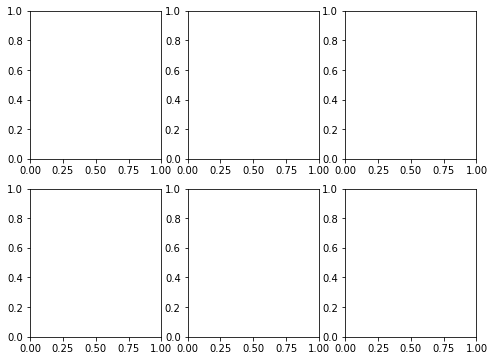

In [14]:
# TODO: use visualize_tensor to visualize the channel 0 of all convolutional layers and max-pooling layers of the first test image in MNIST
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(8, 6))